In [710]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from thefuzz import fuzz
from thefuzz import process

cars = pd.read_csv("./concatenated_data.csv", index_col=0)
del cars["description"]
cars.columns=['brand', 'model', 'price', 'mileage', 'year', 'location',
'date_added', 'body_type', 'fuel', 'power', 'transmission', 'color',
'price_new', 'engine_size']
cars.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9437 entries, 0 to 5880
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         9411 non-null   object 
 1   model         9411 non-null   object 
 2   price         9432 non-null   float64
 3   mileage       9411 non-null   float64
 4   year          9411 non-null   object 
 5   location      9421 non-null   object 
 6   date_added    3336 non-null   object 
 7   body_type     9191 non-null   object 
 8   fuel          9411 non-null   object 
 9   power         9411 non-null   object 
 10  transmission  9411 non-null   object 
 11  color         9400 non-null   object 
 12  price_new     1955 non-null   float64
 13  engine_size   5855 non-null   object 
dtypes: float64(3), object(11)
memory usage: 1.1+ MB


# Overview

In [711]:
cars.describe()

,price,mileage,price_new
count,9.432000e+03,9.411000e+03,1955.000000
mean,3.309366e+07,2.361327e+12,171507.106905
std,1.645900e+09,1.619689e+14,136366.008481
min,-1.000000e+00,-2.200000e+05,29510.000000
25%,8.000000e+03,2.400000e+04,79990.000000
50%,3.300000e+04,1.010000e+05,136480.000000
75%,5.992500e+04,1.800000e+05,215000.000000
max,1.111111e+11,1.111111e+16,908000.000000


In [712]:
def summary_statistics(dataset):
    print(' summary statistics')
    mean = np.round(np.mean(dataset), 2)
    median = np.round(np.nanmedian(dataset), 2)
    min_value = np.round(dataset.min(), 2)
    max_value = np.round(dataset.max(), 2)
    q1 = np.round(dataset.quantile(0.25), 2)
    q3 = np.round(dataset.quantile(0.75), 2)
    # Interquartile range
    iqr = np.round(q3 - q1, 2)
    print('Min: %s' % min_value)
    print('Mean: %s' % mean)
    print('Max: %s' % max_value)
    print('25th percentile: %s' % q1)
    print('Median: %s' % median)
    print('75th percentile: %s' % q3)
    print('Interquartile range (IQR): %s' % iqr)
    

# Numerical Data

## power

Convert N.D to nan in the "power" column

In [ ]:

power_is_ND = cars["power"] == "N.D"
cars.loc[power_is_ND, "power"] = np.nan

Convert the column "power" to float

In [ ]:

contains_CV = cars["power"].str.contains("C") & cars["power"].notna()
cars.loc[contains_CV, "power"] = cars.loc[contains_CV, "power"].apply(
    lambda string: string.split()[0]
)
cars["power"] = cars["power"].astype(np.float64)


If power > 200 -> power = nan

In [ ]:

power_over_200 = cars["power"] > 200
cars.loc[power_over_200, "power"] = np.nan


## price

 summary statistics
Min: -1.0
Mean: 33093662.93
Max: 111111111111.0
25th percentile: 8000.0
Median: 33000.0
75th percentile: 59925.0
Interquartile range (IQR): 51925.0


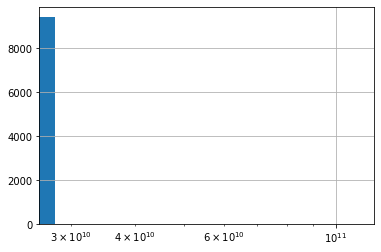

In [713]:
summary_statistics(cars['price'])
cars["price"].hist(bins=4)
plt.xscale('log')
plt.show()

price -> abs(price)
If price is 0 -> price = nan



In [714]:


cars["price"] = abs(cars["price"])
price_is_0 = cars["price"] == 0
cars.loc[price_is_0, "price"] = np.nan



If price over 1_000_000 -> price = nan

In [715]:

price_over_1000000 = cars["price"] >= 1e8
cars.loc[price_over_1000000, "price"] = np.nan


If price less than 500 -> price *= 1000


        brand    model  year   mileage  price
2496      BMW       X6  2008  260000.0   98.0
4444      BMW       X6  2008  260000.0   98.0
5731  Peugeot      301  2014     226.0   97.0
2550     Ford     Kuga  2021   10000.0   97.0
4498     Ford     Kuga  2021   10000.0   97.0
...       ...      ...   ...       ...    ...
4178  Renault       R5  1980     580.0    2.0
5415    Isuzu  Trooper  1990      55.0    2.0
1077  Renault   Symbol  2015  200000.0    2.0
1945  Renault   Symbol  2015  200000.0    2.0
3893  Renault   Symbol  2015  200000.0    2.0

[758 rows x 5 columns]


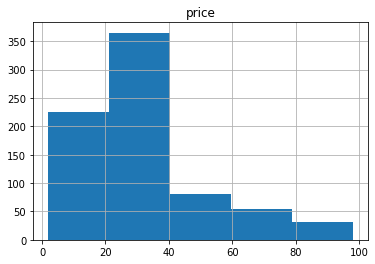

In [716]:

print(cars.loc[(cars["price"] >1) & (cars["price"] <100),["brand","model","year","mileage","price"]].sort_values(by=["price","year"], ascending=[False,True]))
cars.loc[(cars["price"] >1) & (cars["price"] <100),["price","year"]].hist(bins=5)
plt.show()
# price_less_than_1000 = cars["price"] <= 500
# cars.loc[price_less_than_1000, "price"] *= 1000


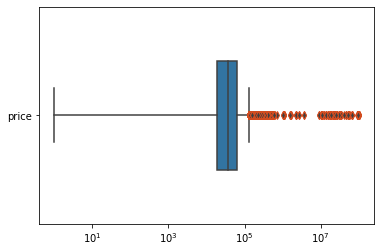

In [717]:

ax = sns.boxplot(data=cars[["price"]],width=0.5,orient='h', flierprops=dict(markeredgecolor="#D94D1F"))
plt.xscale('log')
plt.show()

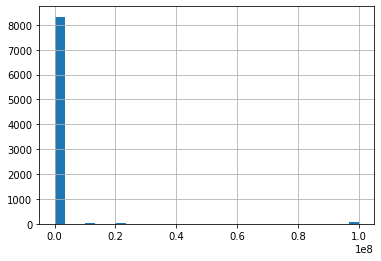

In [718]:
cars["price"].hist(bins=30)
# plt.xscale('log')
plt.show()

Eliminating outliers

In [719]:
def eliminate_outilers_z_score(df,column,threshold=4):
    mean = np.mean(df[column])
    std = np.std(df[column])
    outliers= abs((df[column]-mean)/std)> threshold
    df.loc[outliers,column]=np.nan

In [720]:
def eliminate_outilers_IQR(df,column):
    q1 = np.percentile(df.loc[df[column].notna(), column], 25)
    q3 = np.percentile(df.loc[df[column].notna(), column], 75)

    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers= (df[column ] > upper_bound)| (df[column ] < lower_bound)
    df.loc[outliers,column]=np.nan



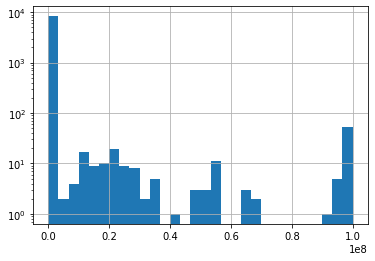

 summary statistics
Min: 1.0
Mean: 1091688.36
Max: 99999999.0
25th percentile: 18500.0
Median: 36000.0
75th percentile: 65000.0
Interquartile range (IQR): 46500.0


In [721]:
cars["price"].hist(bins=30)
plt.yscale('log')
plt.show()
summary_statistics(cars["price"])


In [722]:

eliminate_outilers_IQR(cars,"price")

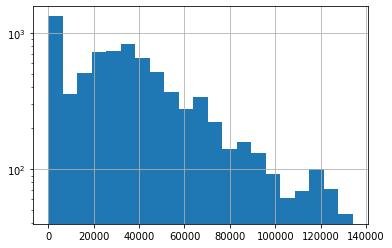

 summary statistics
Min: 1.0
Mean: 37919.92
Max: 134000.0
25th percentile: 16500.0
Median: 33000.0
75th percentile: 53500.0
Interquartile range (IQR): 37000.0


In [723]:
cars["price"].hist(bins=int((109000.0-670.0)/5_000))
plt.yscale('log')
plt.show()
summary_statistics(cars["price"])


In [724]:
cars.loc[cars["price"] > 400_000]


,brand,model,price,mileage,year,location,date_added,body_type,fuel,power,transmission,color,price_new,engine_size


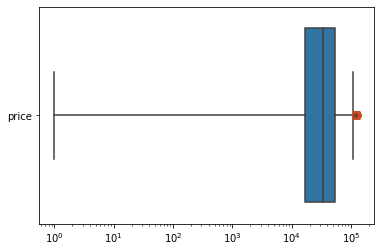

In [725]:
sns.boxplot(data=cars[["price"]], orient="h", flierprops=dict(markeredgecolor="#D94D1F"))
plt.xscale('log')

plt.show()


## mileage

mileage -> abs(mileage)

In [726]:

cars["mileage"] = abs(cars["mileage"])


If mileage < 10 -> mileage = nan

In [727]:

mileage_less_than_10 = cars["mileage"] < 10
cars.loc[mileage_less_than_10, "mileage"] = np.nan


If mileage <= 1000 -> mileage *= 1000

In [728]:

mileage_less_than_1000 = cars["mileage"] <= 1000
cars.loc[mileage_less_than_1000, "mileage"] *= 1000

If mileage >= 1 000 000 -> mileage = nan

In [729]:

mileage_over_1000000 = cars["mileage"] >= 1000000
cars.loc[mileage_over_1000000, "mileage"] = np.nan


# Strings

Applying str.title() to each column and specifying the field datatype

In [730]:

for col in cars.columns:
    if cars[col].dtype == "object":
        cars[col] = cars[col].str.title()


In [770]:
def explore_strings(df,column):
    #specifying the field datatype
    df[column]=df[column].fillna("").astype(str)
    strings=df[column].unique()
    print(f"distinct {column}s : ", strings)
    print(f"number of distinct {column}s : ", len(strings)-1)# do not count ""
    return strings



## location

Exploring the values of "location" column


In [732]:

locations=explore_strings(cars,"location")


distinct locations :  ['Ariana' 'Tunis' 'Ben Arous' 'Bizerte' 'Monastir' 'Béja' 'La Manouba'
 'Sousse' 'Nabeul' 'Sidi Bouzid' 'Gafsa' 'Kairouan' 'Sfax' 'Mahdia'
 'Tozeur' 'Médenine' 'Kasserine' 'Le Kef' 'Gabès' 'Zaghouan' 'Jendouba'
 'Kébili' 'Siliana' 'Manouba' 'Gabes' 'Tataouine' '']
number of distinct locations :  26


In [733]:
def get_matches(df, column, string_to_match,min_ratio=50):
    strings = df[column].unique()
    
    # get the top 10 closest matches to our input string
    matches = process.extract(string_to_match, strings, 
                                         limit=10, scorer=fuzz.token_sort_ratio)
    # print(f'matches of "{string_to_match}" in column {column}', matches)
    #only get matches with a ratio >= min_ratio
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]
    return close_matches
    # print(f'close matches of "{string_to_match}" in column {column}', close_matches)

    

In [762]:
def explore_matches(df,column,ratio=60):
    strings = df[column].unique()
    seen=set()
    for s in strings: 
        if s in seen : 
            continue
        if s== '':
            continue
        close_matches=get_matches(df,column,s,ratio)
        seen.update(close_matches)
        if len(close_matches) >=2 :
            print(f'close matches of {s}: {close_matches}')


In [735]:
explore_matches(cars,"location")

close matches of La Manouba: ['La Manouba', 'Manouba']
close matches of Gabès: ['Gabès', 'Gabes']
close matches of Manouba: ['Manouba', 'La Manouba']
close matches of Gabes: ['Gabes', 'Gabès']


Unify and fix the values of the "location" column


In [736]:

my_dict = {
    "La Manouba": "Manouba",
    "Gabès": "Gabes"
}
cars.replace({"location": my_dict}, inplace=True)


In [737]:
locations=explore_strings(cars, "location")

distinct locations :  ['Ariana' 'Tunis' 'Ben Arous' 'Bizerte' 'Monastir' 'Béja' 'Manouba'
 'Sousse' 'Nabeul' 'Sidi Bouzid' 'Gafsa' 'Kairouan' 'Sfax' 'Mahdia'
 'Tozeur' 'Médenine' 'Kasserine' 'Le Kef' 'Gabes' 'Zaghouan' 'Jendouba'
 'Kébili' 'Siliana' 'Tataouine' '']
number of distinct locations :  24


## color

In [676]:
#specifying the field datatype
# cars.loc[cars["color"]=="nan","color"]=np.nan
colors=explore_strings(cars,"color")
# len(cars[cars["color"].isna()])


distinct colors :  ['Blanc' 'Rouge' 'Noir' 'Gris Shark' 'Beige' 'Bleu' 'Gris Argent'
 'Gris Anthracite' 'Autre' 'Orange' 'Marron' 'Vert' 'Jaune' 'Aubergine'
 'Bleu Roi' 'Gris' 'Bronze' 'Gris Métallisé' 'Gris Foncé' 'Gris Titanuim'
 'Bleu Gris' 'Noire' 'Miel' 'Blanc Cristal' '' 'Bleu/Gris' 'Mauve Gris'
 'Gris Charbon' '*****' 'Blanche' 'Grise' 'Verte' 'Bleu Métallisée'
 'Grise Metalisee' 'Bleu Métallisé' 'Gris Magnetic' 'Gris Clair Métallisé'
 "Feuille D'Argent" 'Maran' 'Grise Métallisée' 'Rouge Bordeaux' 'Camel'
 'Grenadine' 'Titanium' 'Champagne' 'Multicolore' 'Argent' 'Doré' 'Violet'
 'Corail']
number of distinct colors :  49


brouillon

In [629]:
#get all the words that match "gris"
matches = process.extract("gris", colors, limit=20, scorer=fuzz.token_sort_ratio)
#take a look at them to choose min_ratio
matches

[('Gris', 100),
 ('Grise', 89),
 ('Gris Foncé', 62),
 ('Bleu Gris', 62),
 ('Bleu/Gris', 62),
 ('Gris Shark', 57),
 ('Mauve Gris', 57),
 ('Gris Argent', 53),
 ('Gris Métallisé', 50),
 ('Gris Charbon', 50),
 ('Gris Titanuim', 47),
 ('Gris Magnetic', 47),
 ('Grenadine', 46),
 ('Grise Métallisée', 44),
 ('Gris Anthracite', 42),
 ('Grise Metalisee', 42),
 ('Corail', 40),
 ('Gris Clair Métallisé', 36),
 ('Blanc Cristal', 35),
 ('Bleu Roi', 33)]

In [677]:
colors_gris = ["gris" if c.lower().startswith("gris") else c for c in colors]

colors_gris=[c[:-4] if c.lower().endswith("gris")  else c for c in colors_gris]
colors_gris
matches = process.extract("Gris a", colors, limit=30, scorer=fuzz.token_sort_ratio)
score = fuzz.token_sort_ratio("gris ", "Gris Anthracite")
print(score)
matches

42


[('Gris', 80),
 ('Grise', 73),
 ('Gris Argent', 71),
 ('Gris Foncé', 67),
 ('Bleu Gris', 67),
 ('Bleu/Gris', 67),
 ('Gris Charbon', 67),
 ('Gris Anthracite', 57),
 ('Blanc Cristal', 53),
 ('Gris Shark', 50),
 ('Mauve Gris', 50),
 ('Gris Clair Métallisé', 50),
 ('Gris Métallisé', 44),
 ('Bleu Roi', 43),
 ('Gris Titanuim', 42),
 ('Gris Magnetic', 42),
 ('Aubergine', 40),
 ('Grise Métallisée', 40),
 ('Grenadine', 40),
 ('Grise Metalisee', 38),
 ('Autre', 36),
 ('Maran', 36),
 ('Orange', 33),
 ('Marron', 33),
 ('Bleu Métallisé', 33),
 ('Argent', 33),
 ('Corail', 33),
 ('Bleu Métallisée', 32),
 ('Rouge Bordeaux', 30),
 ('Titanium', 29)]

In [678]:
def replace_matches_in_column(df, column, string_to_match, min_ratio = 47):

    # only get matches with a ratio > 90
    close_matches = get_matches(df,column,string_to_match,min_ratio)

    # get the rows of all the close matches in our dataframe
    rows_with_matches = df[column].isin(close_matches)

    # replace all rows with close matches with the input matches 
    df.loc[rows_with_matches, column] = string_to_match
    
    # let us know the function's done
    print("All done!")

In [738]:

def replace_colors(df,column, color):
    shades= [c for c in column if c.lower().strip().startswith(color) ]
    rows_with_matches=df["color"].isin(shades)
    df.loc[rows_with_matches, "color"]=color
     

In [739]:
replace_colors(cars,colors,"gris")
replace_colors(cars,colors,"bleu")
replace_colors(cars,colors,"blanc")
replace_colors(cars,colors,"vert")
replace_colors(cars,colors,"rouge")
replace_colors(cars,colors,"noir")


Unify and fix the values of the "color" column


In [740]:
my_dict = {
    "Argent": "gris",
    "Feuille D'Argent": "gris",
    "Titanium": "gris",
    "Miel": "Doré",
    "Champagne": "Jaune",
    "Grenadine": "Rouge",
    "Rouge Bordeaux": "Rouge",
    "Mauve Gris": "Mauve",
    "Aubergine": "Violet",
    "Maran": "Marron",
    "Corail": "Orange",
}
cars.replace({"color": my_dict}, inplace=True)



If color is "*****" -> color = nan


In [741]:

specified_color = cars["color"] == "*****"
cars[specified_color] = np.nan

In [742]:
colors_clean=explore_strings(cars,"color")

distinct colors :  ['blanc' 'rouge' 'noir' 'gris' 'Beige' 'bleu' 'Autre' 'Orange' 'Marron'
 'vert' 'Jaune' 'Violet' 'Bronze' 'Doré' '' 'Mauve' 'Camel' 'Rouge'
 'Multicolore']
number of distinct colors :  18


In [396]:

# my_dict = {
#     "Blanche": "Blanc",
#     "Blanc Cristal": "Blanc",
#     "Grise": "Gris",
#     "Gris Métallisé": "Gris",
#     "Grise Metalisee": "Gris",
#     "Grise Métallisée": "Gris",
#     "Gris Clair Métallisé": "Gris",
#     "Gris Foncé": "Gris",
#     "Gris Charbon": "Gris",
#     "Gris Magnetic": "Gris",
#     "Bleu Gris": "Bleu",
#     "Bleu/Gris": "Bleu",
#     "Bleu Roi": "Bleu",
#     "Bleu Métallisée": "Bleu",
#     "Gris Titanium": "Argent",
#     "Gris Titanuim": "Argent",
#     "Gris Argent": "Argent",
#     "Feuille D'Argent": "Argent",
#     "Titanium": "Argent",
#     "Miel": "Jaune",
#     "Champagne": "Jaune",
#     "Grenadine": "Rouge",
#     "Rouge Bordeaux": "Rouge",
#     "Mauve Gris": "Violet",
#     "Aubergine": "Violet",
#     "Noire": "Noir",
#     "Maran": "Marron",
#     "Corail": "Orange",
# }
# cars.replace({"color": my_dict}, inplace=True)


## model

In [743]:
models=explore_strings(cars,"model")

distinct models :  ['T Roc' 'Zs' 'Cerato 5P' 'Sportage' 'A4' 'Partner' 'Classe C' 'Gla' 'Q3'
 'Classe B' 'Golf 7' 'Classe C Coupe' 'Serie 3' 'Logan Mcv' 'A3'
 'Ecosport' 'Serie 4 Gran Coupe' '208' 'Ml' 'Clio' 'D Max' '3008' 'Polo'
 'A5 Sportback' 'H 1' 'Cla' 'Classe E Coupe' 'Mondeo' 'Cayenne' '206 Plus'
 'Rio 5P' 'Hs' '3' 'Serie 5' 'Tivoli' 'Compass' '206' 'Q7' '308' 'Leon'
 'Jetta' 'Formentor' 'Macan' 'Qashqai' 'Q2' 'Serie 7' 'Tiguan' 'Fusion'
 'H6' 'Golf 8' 'Focus' 'C3' 'A5 Coupe' 'Staria' 'Viano' 'Doblo' 'H2'
 'Rexton' 'Jolion' 'Discovery' '2008' 'Symbol' 'Passat Cc'
 'Discovery Sport' 'Tiggo 3' 'Classe S' 'E Pace' 'Range Rover Evoque'
 'Ds3' 'Classe A' 'Qx56' 'Polo Sedan' 'F Pace' 'Classe E' 'Seltos' 'Iris'
 'Patrol' 'Ateca' 'Gc 6' 'Picanto' 'Arona' 'Gs' 'Amarok' 'A3 Berline'
 'A3 Sportback' 'Sx3' 'City' 'S5' 'C Hr' 'Mustang' 'Tipo Berline' 'Golf 6'
 'Serie 2 Active Tourer' 'M4' 'Tipo' 'Transit' 'Megane Sedan'
 'Punto Classic' 'Glc Coupe' 'Serie 1 5P' 'Kuv 100' 'Renegade'
 'Partne

In [753]:
# explore_matches(cars,"model")
already=set()
k=0
for m in models:
    if m =='': 
        continue
    if m in already:
        continue

    close_matches=get_matches(cars, "model", m,80)
    already.update(set(close_matches))
    if len(close_matches)>=2 :
        k+=1
        print(f'close matches of {m}: {close_matches}') 

    
print(k)

close matches of Cerato 5P: ['Cerato 5P', 'Cerato']
close matches of A4: ['A4', 'Ax4']
close matches of Classe C: ['Classe C', 'Classe Cla', 'Classe B', 'Classe A']
close matches of Gla: ['Gla', 'Gl']
close matches of Golf 7: ['Golf 7', 'Golf 8', 'Golf 6', 'Golf 5', 'Golf 4', 'Golf 2', 'Golf 3', 'Golf']
close matches of Classe C Coupe: ['Classe C Coupe', 'Classe E Coupe']
close matches of Serie 3: ['Serie 3', 'Serie 5', 'Serie 7', 'Serie 4', 'Serie 1', 'Serie 2', 'Serie 3 Gt']
close matches of Serie 4 Gran Coupe: ['Serie 4 Gran Coupe', 'Serie 2 Gran Coupe', 'Serie 4 Coupe']
close matches of 208: ['208', '2008']
close matches of D Max: ['D Max', 'D-Max']
close matches of 3008: ['3008', '308', '300']
close matches of Polo: ['Polo', 'Polo 7', 'Polo 6', 'Polo 4', 'Polo 3']
close matches of A5 Sportback: ['A5 Sportback', 'A3 Sportback', 'A7 Sportback', 'A1 Sportback', 'Q5 Sportback', 'Q3 Sportback']
close matches of H 1: ['H 1', 'H-1']
close matches of Cla: ['Cla', 'Cl']
close matches of 20

## brand

In [771]:
brands=explore_strings(cars,"brand").sort()

distinct brands :  ['Volkswagen' 'Mg' 'Kia' 'Audi' 'Peugeot' 'Mercedes Benz' 'Bmw' 'Dacia'
 'Ford' 'Renault' 'Isuzu' 'Hyundai' 'Porsche' 'Mazda' 'Ssangyong' 'Jeep'
 'Seat' 'Cupra' 'Nissan' 'Haval' 'Citroen' 'Fiat' 'Land Rover' 'Chery'
 'Jaguar' 'Infiniti' 'Wallyscar' 'Geely' 'Dongfeng' 'Honda' 'Toyota'
 'Great Wall' 'Mahindra' 'Hyundai Trucks' 'Suzuki' 'Byd' 'Skoda' 'Foton'
 'Iveco' 'Opel' 'Mitsubishi' 'Baic Yx' 'Mini' 'Dfsk' 'Chevrolet'
 'Alfa Romeo' 'Gac Motor' 'Hummer' 'Volvo' 'Ds' 'Tata' 'Smart' 'Lada'
 'Lancia' 'Maserati' 'Dodge' 'Land-Rover' 'Mercedes' '' 'Autre Marque'
 'Mercedes-Benz' 'Autres' 'Rover' 'Ac' 'Daewoo' 'Masey Ferguson' 'Gmc'
 'Aston Martin' 'Chrysler' 'Daihatsu' 'Man' 'Changhe']
number of distinct brands :  71


In [775]:
explore_matches(cars,"brand",70)

close matches of Mercedes Benz: ['Mercedes Benz', 'Mercedes-Benz', 'Mercedes']
close matches of Dacia: ['Dacia', 'Lancia']
close matches of Isuzu: ['Isuzu', 'Suzuki']
close matches of Land Rover: ['Land Rover', 'Land-Rover']


In [777]:
my_dict={
    'Mercedes-Benz': 'Mercedes Benz',
    "Mercedes": 'Mercedes Benz',
    'Land-Rover': 'Land Rover'
}
cars.replace({"brand": my_dict}, inplace=True)



In [778]:
brands=explore_strings(cars,"brand")

distinct brands :  ['Volkswagen' 'Mg' 'Kia' 'Audi' 'Peugeot' 'Mercedes Benz' 'Bmw' 'Dacia'
 'Ford' 'Renault' 'Isuzu' 'Hyundai' 'Porsche' 'Mazda' 'Ssangyong' 'Jeep'
 'Seat' 'Cupra' 'Nissan' 'Haval' 'Citroen' 'Fiat' 'Land Rover' 'Chery'
 'Jaguar' 'Infiniti' 'Wallyscar' 'Geely' 'Dongfeng' 'Honda' 'Toyota'
 'Great Wall' 'Mahindra' 'Hyundai Trucks' 'Suzuki' 'Byd' 'Skoda' 'Foton'
 'Iveco' 'Opel' 'Mitsubishi' 'Baic Yx' 'Mini' 'Dfsk' 'Chevrolet'
 'Alfa Romeo' 'Gac Motor' 'Hummer' 'Volvo' 'Ds' 'Tata' 'Smart' 'Lada'
 'Lancia' 'Maserati' 'Dodge' '' 'Autre Marque' 'Autres' 'Rover' 'Ac'
 'Daewoo' 'Masey Ferguson' 'Gmc' 'Aston Martin' 'Chrysler' 'Daihatsu'
 'Man' 'Changhe']
number of distinct brands :  68


## body type

In [780]:
body_types=explore_strings(cars,"body_type")

distinct body_types :  ['Autres' 'Berline' '4 X 4' 'Utilitaire' 'Compacte' 'Monospace' 'Coupé'
 'Citadine' 'Pick Up' 'Cabriolet' '']
number of distinct body_types :  10


## fuel

In [781]:
fuels=explore_strings(cars,"fuel")

distinct fuels :  ['Essence' 'Diesel' 'Hybride (Essence/Électrique)'
 'Hybride (Diesel/Électrique)' 'Hybride Rechargeable' '' 'Electrique'
 'Hybride']
number of distinct fuels :  7


## transmission

In [782]:
transmissions=explore_strings(cars,"transmission")


distinct transmissions :  ['Manuelle' 'Automatique' 'Mécanique' '']
number of distinct transmissions :  3


Convert the column "engine_size" to float

In [ ]:
contains_symbol = cars["engine_size"].str.contains("[><]") & cars["engine_size"].notna()
cars.loc[contains_symbol, "engine_size"] = cars.loc[contains_symbol, "engine_size"].apply(
    lambda string: string[1:]
)
cars.loc[cars["engine_size"].notna(), "engine_size"] = cars.loc[
    cars["engine_size"].notna(), "engine_size"
].apply(lambda string: string[:-1])
cars["engine_size"] = cars["engine_size"].astype(np.float64)


# Dates

Turn "date_added" column to datetime

In [ ]:

contains_hyphen = cars["year"].str.contains("-") & cars["year"].notna()
cars.loc[contains_hyphen, "year"] = cars.loc[contains_hyphen, "year"].apply(
    lambda string: string.split("-")[1]
)
contains_point = cars["year"].str.contains("[.]") & cars["year"].notna()
cars.loc[contains_point, "year"] = cars.loc[contains_point, "year"].apply(
    lambda string: string.split(".")[-1]
)
cars["year"] = cars["year"].astype(np.float64)

If 10<= year <= 23 -> year += 2000, if 60 <= year -> year += 1900, else year = nan

In [ ]:

year_between_0_and_23 = (cars["year"] >= 10) & (cars["year"] <= 23)
cars.loc[year_between_0_and_23, "year"] += 2000
year_more_than_60 = (cars["year"] >= 60) & (cars["year"] <= 99)
cars.loc[year_more_than_60, "year"] += 1900
correct_year = (cars["year"] >= 1960) & (cars["year"] <= 2023)
cars.loc[~correct_year, "year"] = np.nan


Remove month from year in the "year" column and convert it to float

In [ ]:

cars["date_added"] = pd.to_datetime(cars["date_added"])

# Dropping duplicates

In [ ]:

cars.drop_duplicates(inplace=True)


In [ ]:
cars.to_csv("./new_clean_data.csv")
cars.info()
